# Инструкция по загрузке данных и удобной работе с ними

Для начала импортируем файл с классом для загрузки данных.

Вместе с ним импортируются все необходимые для работы библиотеки.

In [1]:
import sys
sys.path.insert(0, 'basic_codes')

import class_magnesium_not_drop_na #_transform_pairings
from class_magnesium_not_drop_na import *

### Прописываем пути до файлов

In [2]:
fold = 'input/'
file_train = 'train.csv'
file_test = 'test.csv'

### Функция для обновления класса
Если вы что-то изменили в class_magnesium_not_drop_na.py, но не хотите перезагружать ядро(чтобы не потерять какие-либо данные), воспользуйтесь этой ячейкой.

In [3]:
import importlib
importlib.reload(class_magnesium_not_drop_na)
from class_magnesium_not_drop_na import *

In [4]:
import numpy as np
import sklearn
from scipy.stats import mode


def bagging(X, y, size):
    indices = np.random.randint(0, len(y), size=size)
    sample_X, sample_y = np.asarray(X[indices]), np.asarray(y[indices])
    return sample_X, sample_y


def bagging(X, y, size):
    indices = np.random.randint(0, len(y), size=size)
    sample_X, sample_y = np.asarray(X[indices]), np.asarray(y[indices])
    return sample_X, sample_y


class RandomForest(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, num_trees: int, max_depth: int, max_features=None, criterion='gini'):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.trees = []

    def update_features(self, n_features):
        if isinstance(self.max_features, float):
            self.max_features = np.int(self.max_features * n_features)
        elif self.max_features == "sqrt":
            self.max_features = np.int(np.sqrt(n_features))
        elif self.max_features == "log2":
            self.max_features = np.int(np.log2(n_features))
        elif self.max_features is None:
            self.max_features = n_features
        elif isinstance(self.max_features, int):
            pass
        else:
            raise ValueError("bad field max_features = {}".format(n_features))

    def fit(self, X_train, y_train):
        """
        Create trees here, using bagging and RSM.
        """
        ## Я решил здесь не исплользовать RSM, так как Decision Tree 
        ## все равно внутри перебирает подмножества признаков
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train)
        self.update_features(X_train.shape[1])
        for i in range(self.num_trees):
            X, y = bagging(X_train, y_train, len(y_train))
            tree = sklearn.tree.DecisionTreeClassifier(criterion=self.criterion,
                                                       max_depth=self.max_depth,
                                                       max_features=self.max_features)
            tree.fit(X, y)
            self.trees.append(tree)
        return self

    @staticmethod
    def mode(answers, *args, **kwargs):
        return mode(answers, *args, **kwargs)[0][0]

    def predict(self, X_test):
        """
        Predict the label here using your grown trees.
        """
        answers = np.array([tree.predict(X_test) for tree in self.trees])
        return self.mode(answers, axis=0)

    def predict_proba(self, X_test):
        """
        Predict the label here using your grown trees.
        """
        answers = np.array([tree.predict_proba(X_test) for tree in self.trees])
        return np.mean(answers, axis=0)
    
    

In [5]:
r = RandomForest(num_trees=40, max_depth=10, max_features=0.5)

In [6]:
from catboost import CatBoostClassifier

import xgboost as xgb

In [9]:
model = CatBoostClassifier(iterations=5, depth=10, learning_rate=1, loss_function='Logloss', logging_level='Verbose')

In [175]:
from sklearn.model_selection import train_test_split
model = xgb.XGBClassifier(nthread=30, n_jobs=10)

### Инициируем класс 

In [178]:
'''
    Класс Magnesium загружает данные из файла file_, находящегося в папке fold. Делает dropna (чтобы кас не ругался)
    model - модель, с которой вы хотите работатьб по умолчанию RFC
    Сохраняет переменные:
    data - загруженный DataFrame
    features - признаки
    groups - цепочки
    x - данные для бучения в виде Numpy-матрицы
    y - целевой признак
'''
# Можно написать любую свою модель
m = Magnesium(file_train, fold = fold, model = model)

Everything is OK. Ready for your experiments!

In [137]:
dtrain = xgb.DMatrix(m.x, label=m.y)
dtest = xgb.DMatrix(test["x"])
# print(test["x"].shape)

In [138]:
param = {
    'max_depth': 40,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

In [139]:
bst = xgb.train(param, dtrain, num_round)

In [140]:
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

In [141]:
print(best_predsds.shape)

(4045,)


In [143]:
with open("out.txt", "w") as out_f:
    print("Id,mg", file=out_f)
    for i, ans in enumerate(best_preds):
        print("{},{}".format(i, ans), file=out_f)


In [132]:
test['data']['Id'].values

array([   0,    1,    2, ..., 4042, 4043, 4044])

In [97]:
best_preds = np.asarray([np.argmax(line) for line in preds])

In [84]:
from sklearn.metrics import precision_score
print(f1_score(y_test, best_preds, average='macro'))

0.6312465786266577


In [190]:
X_train, X_test, y_train, y_test = train_test_split(
    m.x,
    m.y,
    test_size=0.25,
    random_state=42)

In [196]:
grid = {}
grid['max_depth'] = np.array([x for x in range(5, 10)])
grid['n_estimators'] = np.array([x for x in range(15, 40, 5)])
grid['scale_pos_weight'] = np.array([x for x in np.linspace(0.1, 1, 5)])
gs = GridSearchCV(xgb.XGBClassifier(nthread=25, njobs=10), grid, cv=2, scoring='f1', verbose=2)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 125 candidates, totalling 250 fits
[CV] max_depth=5, n_estimators=15, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  max_depth=5, n_estimators=15, scale_pos_weight=0.1, total=   1.8s
[CV] max_depth=5, n_estimators=15, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=15, scale_pos_weight=0.1, total=   1.7s
[CV] max_depth=5, n_estimators=15, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=15, scale_pos_weight=0.325, total=   1.7s
[CV] max_depth=5, n_estimators=15, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=15, scale_pos_weight=0.325, total=   1.8s
[CV] max_depth=5, n_estimators=15, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=15, scale_pos_weight=0.55, total=   1.7s
[CV] max_depth=5, n_estimators=15, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=15, scale_pos_weight=0.55, total=   1.8s
[CV] max_depth=5, n_estimators=15, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=15, scale_pos_weight=0.775, total=   1.8s
[CV] max_depth=5, n_estimators=15, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=15, scale_pos_weight=0.775, total=   1.8s
[CV] max_depth=5, n_estimators=15, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=15, scale_pos_weight=1.0, total=   1.7s
[CV] max_depth=5, n_estimators=15, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=15, scale_pos_weight=1.0, total=   1.7s
[CV] max_depth=5, n_estimators=20, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=20, scale_pos_weight=0.1, total=   2.0s
[CV] max_depth=5, n_estimators=20, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=20, scale_pos_weight=0.1, total=   2.0s
[CV] max_depth=5, n_estimators=20, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=20, scale_pos_weight=0.325, total=   2.0s
[CV] max_depth=5, n_estimators=20, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=20, scale_pos_weight=0.325, total=   2.1s
[CV] max_depth=5, n_estimators=20, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=20, scale_pos_weight=0.55, total=   2.0s
[CV] max_depth=5, n_estimators=20, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=20, scale_pos_weight=0.55, total=   2.1s
[CV] max_depth=5, n_estimators=20, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=20, scale_pos_weight=0.775, total=   2.0s
[CV] max_depth=5, n_estimators=20, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=20, scale_pos_weight=0.775, total=   2.1s
[CV] max_depth=5, n_estimators=20, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=20, scale_pos_weight=1.0, total=   2.1s
[CV] max_depth=5, n_estimators=20, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=20, scale_pos_weight=1.0, total=   2.1s
[CV] max_depth=5, n_estimators=25, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=25, scale_pos_weight=0.1, total=   2.3s
[CV] max_depth=5, n_estimators=25, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=25, scale_pos_weight=0.1, total=   2.3s
[CV] max_depth=5, n_estimators=25, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=25, scale_pos_weight=0.325, total=   2.4s
[CV] max_depth=5, n_estimators=25, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=25, scale_pos_weight=0.325, total=   2.3s
[CV] max_depth=5, n_estimators=25, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=25, scale_pos_weight=0.55, total=   2.4s
[CV] max_depth=5, n_estimators=25, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=25, scale_pos_weight=0.55, total=   2.3s
[CV] max_depth=5, n_estimators=25, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=25, scale_pos_weight=0.775, total=   2.3s
[CV] max_depth=5, n_estimators=25, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=25, scale_pos_weight=0.775, total=   2.4s
[CV] max_depth=5, n_estimators=25, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=25, scale_pos_weight=1.0, total=   2.4s
[CV] max_depth=5, n_estimators=25, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=25, scale_pos_weight=1.0, total=   2.3s
[CV] max_depth=5, n_estimators=30, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=30, scale_pos_weight=0.1, total=   2.6s
[CV] max_depth=5, n_estimators=30, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=30, scale_pos_weight=0.1, total=   2.6s
[CV] max_depth=5, n_estimators=30, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=30, scale_pos_weight=0.325, total=   2.7s
[CV] max_depth=5, n_estimators=30, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=30, scale_pos_weight=0.325, total=   2.7s
[CV] max_depth=5, n_estimators=30, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=30, scale_pos_weight=0.55, total=   2.7s
[CV] max_depth=5, n_estimators=30, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=30, scale_pos_weight=0.55, total=   2.6s
[CV] max_depth=5, n_estimators=30, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=30, scale_pos_weight=0.775, total=   2.7s
[CV] max_depth=5, n_estimators=30, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=30, scale_pos_weight=0.775, total=   2.6s
[CV] max_depth=5, n_estimators=30, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=30, scale_pos_weight=1.0, total=   2.7s
[CV] max_depth=5, n_estimators=30, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=30, scale_pos_weight=1.0, total=   2.7s
[CV] max_depth=5, n_estimators=35, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=35, scale_pos_weight=0.1, total=   2.9s
[CV] max_depth=5, n_estimators=35, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=35, scale_pos_weight=0.1, total=   2.9s
[CV] max_depth=5, n_estimators=35, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=35, scale_pos_weight=0.325, total=   3.0s
[CV] max_depth=5, n_estimators=35, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=35, scale_pos_weight=0.325, total=   3.0s
[CV] max_depth=5, n_estimators=35, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=35, scale_pos_weight=0.55, total=   3.0s
[CV] max_depth=5, n_estimators=35, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=35, scale_pos_weight=0.55, total=   2.9s
[CV] max_depth=5, n_estimators=35, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=35, scale_pos_weight=0.775, total=   3.0s
[CV] max_depth=5, n_estimators=35, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=35, scale_pos_weight=0.775, total=   3.0s
[CV] max_depth=5, n_estimators=35, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=35, scale_pos_weight=1.0, total=   2.9s
[CV] max_depth=5, n_estimators=35, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=5, n_estimators=35, scale_pos_weight=1.0, total=   3.0s
[CV] max_depth=6, n_estimators=15, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=15, scale_pos_weight=0.1, total=   1.8s
[CV] max_depth=6, n_estimators=15, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=15, scale_pos_weight=0.1, total=   1.8s
[CV] max_depth=6, n_estimators=15, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=15, scale_pos_weight=0.325, total=   2.0s
[CV] max_depth=6, n_estimators=15, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=15, scale_pos_weight=0.325, total=   1.9s
[CV] max_depth=6, n_estimators=15, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=15, scale_pos_weight=0.55, total=   1.9s
[CV] max_depth=6, n_estimators=15, scale_pos_weight=0.55 .............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=15, scale_pos_weight=0.55, total=   1.9s
[CV] max_depth=6, n_estimators=15, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=15, scale_pos_weight=0.775, total=   1.9s
[CV] max_depth=6, n_estimators=15, scale_pos_weight=0.775 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=15, scale_pos_weight=0.775, total=   2.0s
[CV] max_depth=6, n_estimators=15, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=15, scale_pos_weight=1.0, total=   1.9s
[CV] max_depth=6, n_estimators=15, scale_pos_weight=1.0 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=15, scale_pos_weight=1.0, total=   1.9s
[CV] max_depth=6, n_estimators=20, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=20, scale_pos_weight=0.1, total=   2.2s
[CV] max_depth=6, n_estimators=20, scale_pos_weight=0.1 ..............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=20, scale_pos_weight=0.1, total=   2.2s
[CV] max_depth=6, n_estimators=20, scale_pos_weight=0.325 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  max_depth=6, n_estimators=20, scale_pos_weight=0.325, total=   2.3s
[CV] max_depth=6, n_estimators=20, scale_pos_weight=0.325 ............


KeyboardInterrupt: 

In [198]:
grid = {}
grid['n_estimators'] = np.array([x for x in range(15, 40, 5)])
grid['scale_pos_weight'] = np.array([x for x in np.linspace(0.1, 1, 10)])
gs = GridSearchCV(xgb.XGBClassifier(nthread=30, njobs=10, max_depth=10), grid,cv=2, scoring='f1', verbose=2)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] n_estimators=15, scale_pos_weight=0.1 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] ............ n_estimators=15, scale_pos_weight=0.1, total=   2.2s
[CV] n_estimators=15, scale_pos_weight=0.1 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.1, total=   2.3s
[CV] n_estimators=15, scale_pos_weight=0.2 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.2, total=   2.6s
[CV] n_estimators=15, scale_pos_weight=0.2 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.2, total=   2.5s
[CV] n_estimators=15, scale_pos_weight=0.30000000000000004 ...........


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=15, scale_pos_weight=0.30000000000000004, total=   2.6s
[CV] n_estimators=15, scale_pos_weight=0.30000000000000004 ...........


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=15, scale_pos_weight=0.30000000000000004, total=   2.6s
[CV] n_estimators=15, scale_pos_weight=0.4 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.4, total=   2.6s
[CV] n_estimators=15, scale_pos_weight=0.4 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.4, total=   2.6s
[CV] n_estimators=15, scale_pos_weight=0.5 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.5, total=   2.6s
[CV] n_estimators=15, scale_pos_weight=0.5 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.5, total=   2.6s
[CV] n_estimators=15, scale_pos_weight=0.6 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.6, total=   2.7s
[CV] n_estimators=15, scale_pos_weight=0.6 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.6, total=   2.6s
[CV] n_estimators=15, scale_pos_weight=0.7000000000000001 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=15, scale_pos_weight=0.7000000000000001, total=   2.7s
[CV] n_estimators=15, scale_pos_weight=0.7000000000000001 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=15, scale_pos_weight=0.7000000000000001, total=   2.6s
[CV] n_estimators=15, scale_pos_weight=0.8 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.8, total=   2.7s
[CV] n_estimators=15, scale_pos_weight=0.8 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.8, total=   2.6s
[CV] n_estimators=15, scale_pos_weight=0.9 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.9, total=   2.7s
[CV] n_estimators=15, scale_pos_weight=0.9 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=0.9, total=   2.7s
[CV] n_estimators=15, scale_pos_weight=1.0 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=1.0, total=   2.7s
[CV] n_estimators=15, scale_pos_weight=1.0 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=15, scale_pos_weight=1.0, total=   2.7s
[CV] n_estimators=20, scale_pos_weight=0.1 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.1, total=   2.8s
[CV] n_estimators=20, scale_pos_weight=0.1 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.1, total=   2.9s
[CV] n_estimators=20, scale_pos_weight=0.2 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.2, total=   3.2s
[CV] n_estimators=20, scale_pos_weight=0.2 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.2, total=   3.2s
[CV] n_estimators=20, scale_pos_weight=0.30000000000000004 ...........


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=20, scale_pos_weight=0.30000000000000004, total=   3.2s
[CV] n_estimators=20, scale_pos_weight=0.30000000000000004 ...........


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=20, scale_pos_weight=0.30000000000000004, total=   3.2s
[CV] n_estimators=20, scale_pos_weight=0.4 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.4, total=   3.3s
[CV] n_estimators=20, scale_pos_weight=0.4 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.4, total=   3.2s
[CV] n_estimators=20, scale_pos_weight=0.5 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.5, total=   3.3s
[CV] n_estimators=20, scale_pos_weight=0.5 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.5, total=   3.2s
[CV] n_estimators=20, scale_pos_weight=0.6 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.6, total=   3.3s
[CV] n_estimators=20, scale_pos_weight=0.6 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.6, total=   3.2s
[CV] n_estimators=20, scale_pos_weight=0.7000000000000001 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=20, scale_pos_weight=0.7000000000000001, total=   3.3s
[CV] n_estimators=20, scale_pos_weight=0.7000000000000001 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=20, scale_pos_weight=0.7000000000000001, total=   3.3s
[CV] n_estimators=20, scale_pos_weight=0.8 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.8, total=   3.3s
[CV] n_estimators=20, scale_pos_weight=0.8 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.8, total=   3.3s
[CV] n_estimators=20, scale_pos_weight=0.9 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.9, total=   3.3s
[CV] n_estimators=20, scale_pos_weight=0.9 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=0.9, total=   3.3s
[CV] n_estimators=20, scale_pos_weight=1.0 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=1.0, total=   3.3s
[CV] n_estimators=20, scale_pos_weight=1.0 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=20, scale_pos_weight=1.0, total=   3.3s
[CV] n_estimators=25, scale_pos_weight=0.1 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.1, total=   3.4s
[CV] n_estimators=25, scale_pos_weight=0.1 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.1, total=   3.4s
[CV] n_estimators=25, scale_pos_weight=0.2 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.2, total=   3.7s
[CV] n_estimators=25, scale_pos_weight=0.2 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.2, total=   3.8s
[CV] n_estimators=25, scale_pos_weight=0.30000000000000004 ...........


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=25, scale_pos_weight=0.30000000000000004, total=   3.8s
[CV] n_estimators=25, scale_pos_weight=0.30000000000000004 ...........


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=25, scale_pos_weight=0.30000000000000004, total=   3.8s
[CV] n_estimators=25, scale_pos_weight=0.4 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.4, total=   3.9s
[CV] n_estimators=25, scale_pos_weight=0.4 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.4, total=   3.8s
[CV] n_estimators=25, scale_pos_weight=0.5 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.5, total=   3.9s
[CV] n_estimators=25, scale_pos_weight=0.5 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.5, total=   3.8s
[CV] n_estimators=25, scale_pos_weight=0.6 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.6, total=   3.9s
[CV] n_estimators=25, scale_pos_weight=0.6 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.6, total=   3.9s
[CV] n_estimators=25, scale_pos_weight=0.7000000000000001 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=25, scale_pos_weight=0.7000000000000001, total=   3.9s
[CV] n_estimators=25, scale_pos_weight=0.7000000000000001 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=25, scale_pos_weight=0.7000000000000001, total=   3.9s
[CV] n_estimators=25, scale_pos_weight=0.8 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.8, total=   3.9s
[CV] n_estimators=25, scale_pos_weight=0.8 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.8, total=   3.9s
[CV] n_estimators=25, scale_pos_weight=0.9 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.9, total=   3.9s
[CV] n_estimators=25, scale_pos_weight=0.9 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=0.9, total=   3.9s
[CV] n_estimators=25, scale_pos_weight=1.0 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=1.0, total=   4.0s
[CV] n_estimators=25, scale_pos_weight=1.0 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=25, scale_pos_weight=1.0, total=   3.9s
[CV] n_estimators=30, scale_pos_weight=0.1 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.1, total=   4.0s
[CV] n_estimators=30, scale_pos_weight=0.1 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.1, total=   4.1s
[CV] n_estimators=30, scale_pos_weight=0.2 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.2, total=   4.4s
[CV] n_estimators=30, scale_pos_weight=0.2 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.2, total=   4.4s
[CV] n_estimators=30, scale_pos_weight=0.30000000000000004 ...........


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=30, scale_pos_weight=0.30000000000000004, total=   4.5s
[CV] n_estimators=30, scale_pos_weight=0.30000000000000004 ...........


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=30, scale_pos_weight=0.30000000000000004, total=   4.4s
[CV] n_estimators=30, scale_pos_weight=0.4 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.4, total=   4.5s
[CV] n_estimators=30, scale_pos_weight=0.4 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.4, total=   4.5s
[CV] n_estimators=30, scale_pos_weight=0.5 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.5, total=   4.5s
[CV] n_estimators=30, scale_pos_weight=0.5 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.5, total=   4.5s
[CV] n_estimators=30, scale_pos_weight=0.6 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.6, total=   4.5s
[CV] n_estimators=30, scale_pos_weight=0.6 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.6, total=   4.5s
[CV] n_estimators=30, scale_pos_weight=0.7000000000000001 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=30, scale_pos_weight=0.7000000000000001, total=   4.6s
[CV] n_estimators=30, scale_pos_weight=0.7000000000000001 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=30, scale_pos_weight=0.7000000000000001, total=   4.5s
[CV] n_estimators=30, scale_pos_weight=0.8 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.8, total=   4.6s
[CV] n_estimators=30, scale_pos_weight=0.8 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.8, total=   4.6s
[CV] n_estimators=30, scale_pos_weight=0.9 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.9, total=   4.6s
[CV] n_estimators=30, scale_pos_weight=0.9 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=0.9, total=   4.6s
[CV] n_estimators=30, scale_pos_weight=1.0 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=1.0, total=   4.6s
[CV] n_estimators=30, scale_pos_weight=1.0 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=30, scale_pos_weight=1.0, total=   4.6s
[CV] n_estimators=35, scale_pos_weight=0.1 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.1, total=   4.6s
[CV] n_estimators=35, scale_pos_weight=0.1 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.1, total=   4.7s
[CV] n_estimators=35, scale_pos_weight=0.2 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.2, total=   5.0s
[CV] n_estimators=35, scale_pos_weight=0.2 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.2, total=   5.0s
[CV] n_estimators=35, scale_pos_weight=0.30000000000000004 ...........


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=35, scale_pos_weight=0.30000000000000004, total=   5.1s
[CV] n_estimators=35, scale_pos_weight=0.30000000000000004 ...........


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=35, scale_pos_weight=0.30000000000000004, total=   5.0s
[CV] n_estimators=35, scale_pos_weight=0.4 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.4, total=   5.1s
[CV] n_estimators=35, scale_pos_weight=0.4 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.4, total=   5.1s
[CV] n_estimators=35, scale_pos_weight=0.5 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.5, total=   5.1s
[CV] n_estimators=35, scale_pos_weight=0.5 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.5, total=   5.1s
[CV] n_estimators=35, scale_pos_weight=0.6 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.6, total=   5.1s
[CV] n_estimators=35, scale_pos_weight=0.6 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.6, total=   5.2s
[CV] n_estimators=35, scale_pos_weight=0.7000000000000001 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=35, scale_pos_weight=0.7000000000000001, total=   5.2s
[CV] n_estimators=35, scale_pos_weight=0.7000000000000001 ............


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=35, scale_pos_weight=0.7000000000000001, total=   5.1s
[CV] n_estimators=35, scale_pos_weight=0.8 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.8, total=   5.2s
[CV] n_estimators=35, scale_pos_weight=0.8 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.8, total=   5.2s
[CV] n_estimators=35, scale_pos_weight=0.9 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.9, total=   5.3s
[CV] n_estimators=35, scale_pos_weight=0.9 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=0.9, total=   5.1s
[CV] n_estimators=35, scale_pos_weight=1.0 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ............ n_estimators=35, scale_pos_weight=1.0, total=   5.2s
[CV] n_estimators=35, scale_pos_weight=1.0 ...........................


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.2min finished


[CV] ............ n_estimators=35, scale_pos_weight=1.0, total=   5.2s


({'n_estimators': 35, 'scale_pos_weight': 1.0}, 0.11558140948116959)

In [145]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [146]:

param = {
'max_depth': 45,  # the maximum depth of each tree
'eta': 0.3,  # the training step for each iteration
#     'silent': 0,  # logging mode - quiet
'objective': 'multi:softprob',  # error evaluation for multiclass training
'num_class': 2,
'n_jobs': 10,
'nthread': 25}  # the number of classes that exist in this datset
num_round = 20 # the number of training iterations
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print(md, f1_score(y_test, best_preds, average='macro'))

40 0.7855346134819943


40 0.7416029959039245


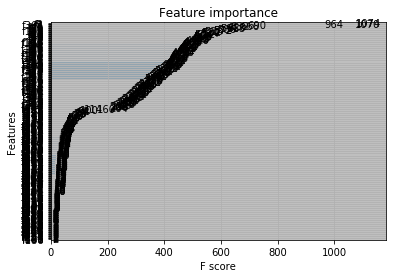

In [148]:

param = {
'max_depth': 20, # the maximum depth of each tree
'eta': 0.2, # the training step for each iteration
'silent': 1, # logging mode - quiet
'objective': 'multi:softprob', # error evaluation for multiclass training
'num_class': 2,
'gamma': 2,
'min_child_weight': 2,
'eval_metric': 'error',
'n_jobs': 10,
'nthread': 25} # the number of classes that exist in this datset
num_round = 20 # the number of training iterations
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print(md, f1_score(y_test, best_preds, average='macro'))
xgb.plot_importance(bst)

In [167]:

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=10, nthread=30, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

,pdb_chain,xray,resol,chainlen,protein,alpham2,betam2,gammam2,deltam2,epsilonm2,...,atomO2p,atomO3p,atomO4,atomO4p,atomO5p,atomO6,atomOP1,atomOP2,atomOP3,mg
35,1b23.cif1_R,1,2.6,74,1,-60.0,177.7,50.4,84.8,-150.6,...,0,0,0,0,0,0,1,0,0,0
36,1b23.cif1_R,1,2.6,74,1,-60.0,177.7,50.4,84.8,-150.6,...,0,0,0,0,0,0,0,1,0,0
37,1b23.cif1_R,1,2.6,74,1,-60.0,177.7,50.4,84.8,-150.6,...,0,0,0,0,1,0,0,0,0,0
38,1b23.cif1_R,1,2.6,74,1,-60.0,177.7,50.4,84.8,-150.6,...,0,0,0,1,0,0,0,0,0,0
39,1b23.cif1_R,1,2.6,74,1,-60.0,177.7,50.4,84.8,-150.6,...,0,1,0,0,0,0,0,0,0,0


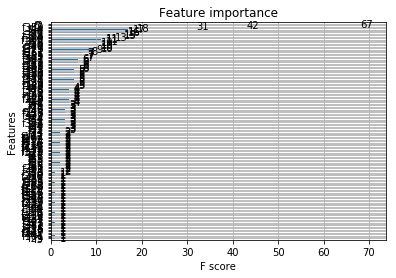

In [168]:
model = xgb.XGBClassifier(nthread=30, n_jobs=10)
model.fit(X_train, y_train)
# plot feature importance
xgb.plot_importance(model)
plt.show()

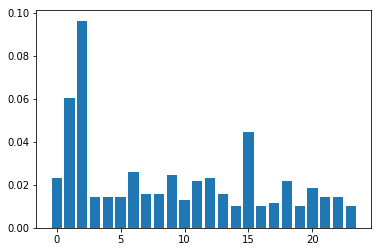

In [174]:
# print(model.feature_importances_)
# plot
f = model.feature_importances_
f = f[f > 0.01]
plt.bar(range(len(f)), f)
plt.show()

In [77]:
for md in [5, 8, 20, 40]:
    param = {
    'max_depth': md,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
#     'silent': 0,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2,
    'n_jobs': 10,
    'nthread': 25}  # the number of classes that exist in this datset
    num_round = 10  # the number of training iterations
    bst = xgb.train(param, dtrain, num_round)
    preds = bst.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    print(md, f1_score(y_test, best_preds, average='macro'))

5 0.4687566716672965
8 0.502270683246175
20 0.7432831884550137
40 0.7777053625933179


/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

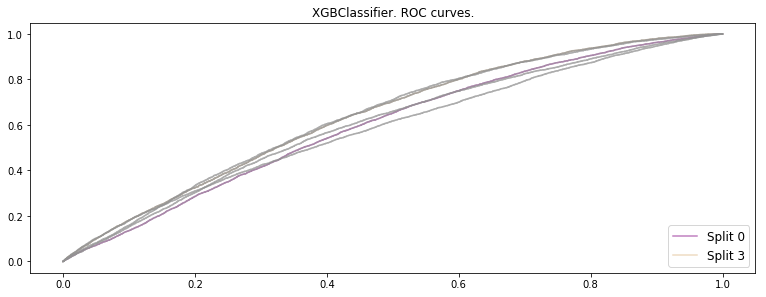

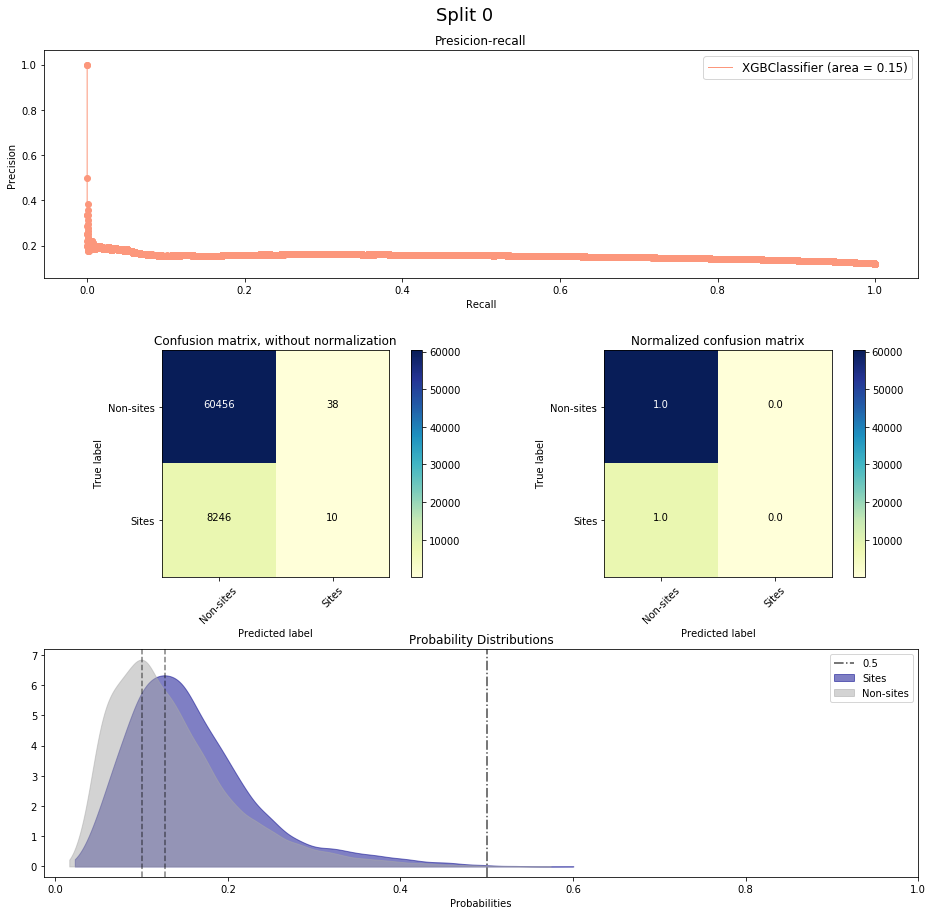

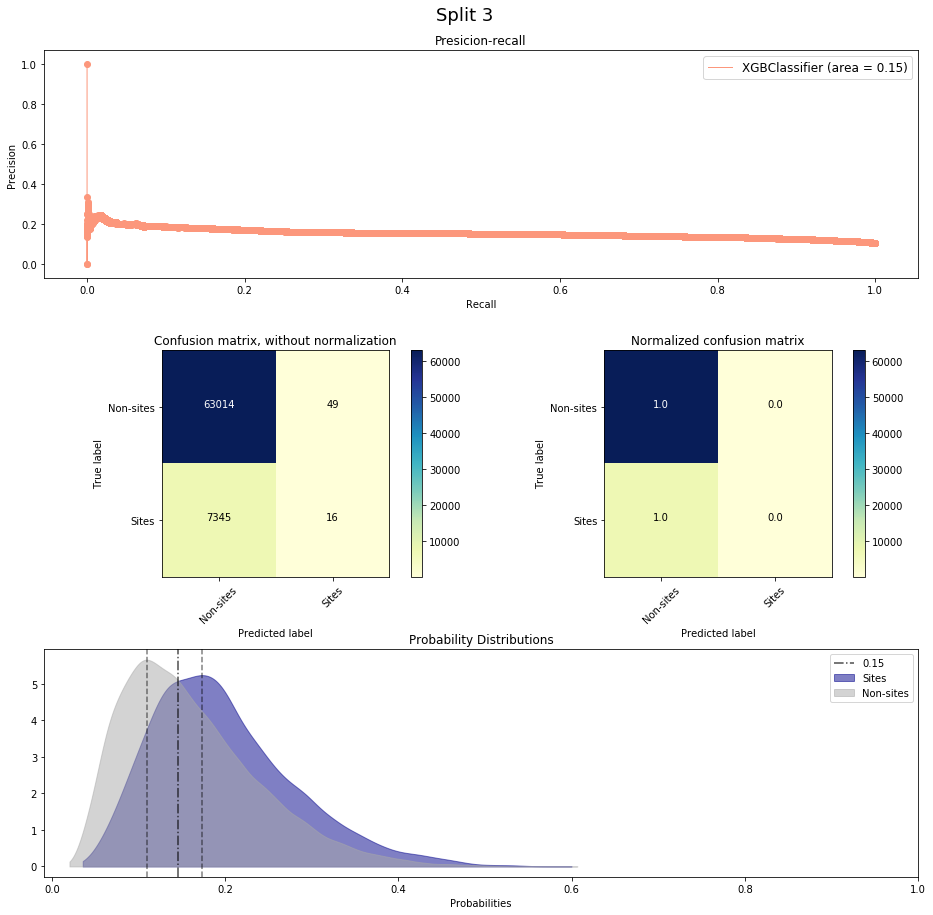

In [188]:
# P.s. эта ячейка порождает много графиков, чтобы не пришлось их скроллить Cell -> Current Outputs -> Toggle Scrolling
'''
  fit_predict осуществляет кроссвалидацию по следуюещему пайплайну:
            если with_groups = True делит выборку с помощью GroupShuffleSplit,
            если False - StratifiedShuffleSplit. 
            C биологической точки зрения логичнее делать разбиения с учетом групп, 
            так как группами являются цепочки => хорошо иметь данные всей цепочки в трейне.
  n_splits, test_size - параметры, окторые передаются GroupShuffleSplit или StratifiedShuffleSplit
  model - можете написать любую свою модель, по дефолту будет брать ту, которая была заложена при создании класса.
  plots - рисовать графики (ROC-AUC, precision-recall, confusion matrix, probability-densities) или нет
  plot_splits - для каких разбиений рисовать графики (разиения нумеруются с 0). По дефолту рисуется для последнего разюиения.
  x , y  - при желании можете подставить свои данные для кросс валидации. По дефолту берет загруженную выборку.
  
  Возвращает словарь с ключами:
  'test score', 'train score' - f1_score на всех сплитах
  'roc_auc': данные функции sklearn.metrics.roc_curve(y_test, y_prob)
  'prec_rec':[precision, recall, average_precision_score, prec_recall_plot]
  'confusion': [cnf_matrix, cnf_normed, cnf_plot, cnf_normed_plot] (normed - означает нормированная матрица)
  'plots':{'roc_auc', 'prec_recall', 'cnf_normed', 'cnf', 'prob_density'}
'''
data = m.fit_predict(n_splits = 5, plot_splits = [0,3]);

In [189]:
data["test score"]

[0.002408477842003854,
 0.002408477842003854,
 0.0004338394793926247,
 0.0026990553306342783,
 0.0043091839482897925,
 0.002747939045715713,
 0.002408477842003854,
 0.0004338394793926247,
 0.0026990553306342783,
 0.0043091839482897925,
 0.002747939045715713]

In [182]:
model.fit(m.x, m.y)
y_pred = model.predict(m.x)

/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [179]:
def load_data(filename):
    '''
        Функция для загрузки датасета без инициализации класса. 
        
        Возвращает:
         data - полный DataFrame
         fetures - список признаков для обучения/предсказания
         x - датасет для тренировки/предсказания в формате np.array
         y - целевой признак, если он есть. В случае с тестовым датасетом возвращает None
    '''
    
    data = pd.read_table(filename, sep=',').dropna()    
    
    data = data[~(data['chainlen']>1000)]

    if ('DSSR' in data.columns):
        data.drop('DSSR', axis=1, inplace=True)    
    
    features = list(deepcopy(data.columns))
    [features.remove(column) for column in ['Id','index', 'pdb_chain', 'mg'] if column in data.columns];
    x_test = np.array(data[features])
    
    try:
        y_test = np.array(data['mg'])
    except: 
        y_test = None
    change_output('Data loaded')
    return {'data':data, 'features':features, 'x':x_test, 'y':y_test}

In [87]:
test = load_data(fold+file_test)

Data loaded

### Тренируем модель на тренировочном датасете

In [183]:
m.trained_model = deepcopy(m.model)
m.trained_model.fit(m.x, m.y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=10, nthread=30, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ulyanin/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


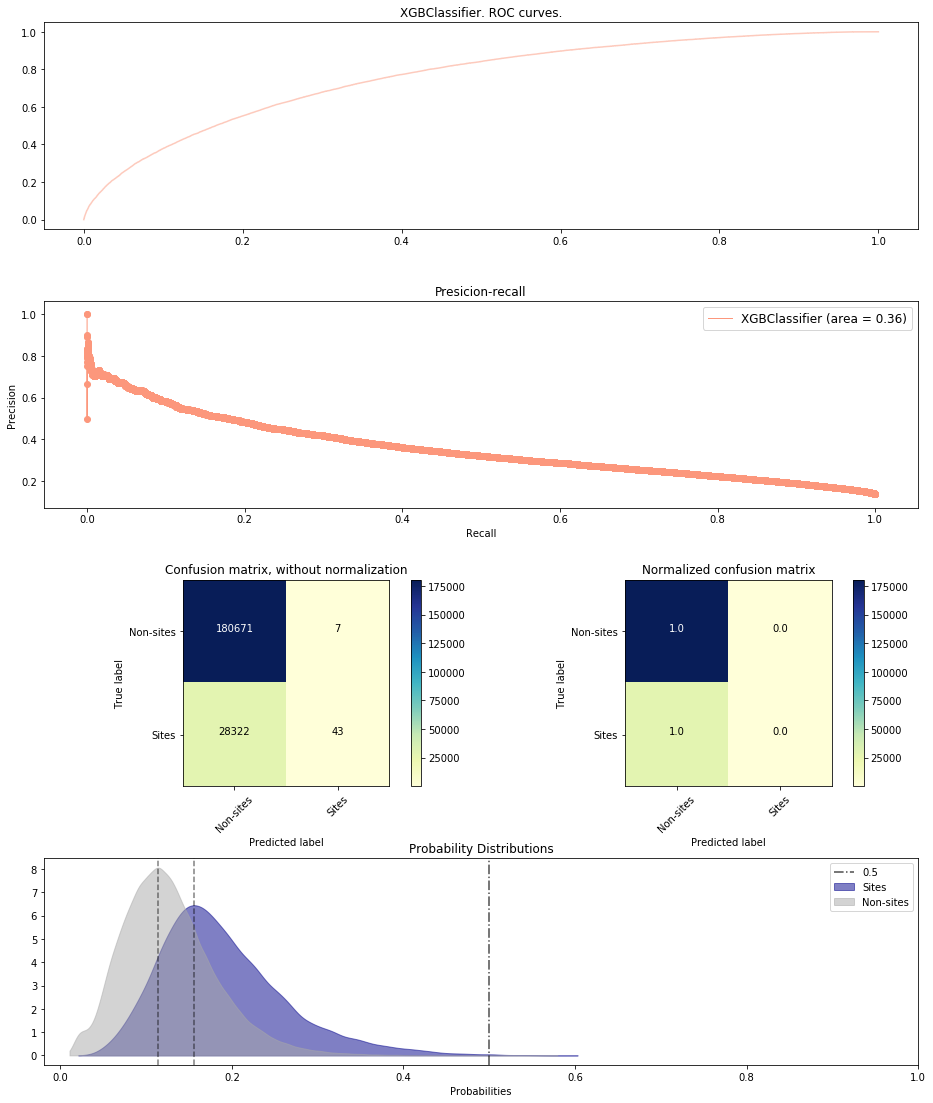

In [184]:
'''
   фунцкия класса Magnesium predict позволяет предказать с помощью натренированной модели 
   (по дефолту она берется из класса, но можно передать и извне в параметре model) на данных x, y;
   Оценить качество предсказания и построить графики. 
   Вовзращает словарь, аналогичный fit_predict.
   И по умолчанию рисует графики метрик качества, аналогичные fit_predict.
   
   Ecли y == None, все оценки качества и графики имеют значения None.
'''
predict_train =  m.predict(x = m.x, 
                           y = m.y,
                           model=m.trained_model, 
                           plots = True)
predict_test =  m.predict(x = test['x'], 
                          y = test['y'],
                          model=m.trained_model,
                          plots = False)

In [16]:
from sklearn.metrics import accuracy_score, mean_squared_error

### Примечание

Для того, чтобы графики можно было строить в каком угодно порядке и комбинировать с другими, каждый график сохранется как список строк. Чтобы построить его, используйте функцию plot_one_plot. (P.s. она написана в файле с классом, продублирую ее здесь)

In [185]:
def plot_one_plot(plot_elements):
    [eval(plot_string) for plot_string in plot_elements]

Пример ее использования:

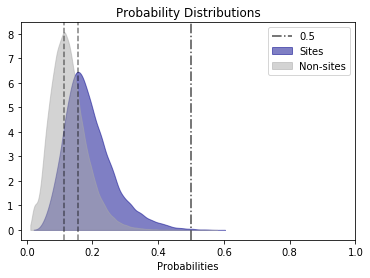

In [186]:
plot_one_plot(predict_train['plots']['prob_density'])

In [147]:
import pandas as pd